In [3]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 2.0 MB 1.1 MB/s eta 0:00:01


In [ ]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time

### 0 基础

multiprocessing 是多进程的意思，这可以与我们之间介绍的多线程（**Threading**）和多进程相对应上，为什么需要多进程？正常启动Python我们仅有一个核在运行，如果电脑是8核或者16核？岂不是很浪费电脑资源？GIL锁针对单线程，多线程不受到限制。

所以，我们该如何利用多核run我们的程序？首先，我们要知道如何启动多线程？

In [1]:
import multiprocessing as mp
import os

def job(school:str, student:str):
    print('Process:{}, {} from {}'.format(os.getpid(), student, school))
    print('- * '*8)
    
# 注意args参数需要要加一个‘,’，表示可迭代对象。
p1 = mp.Process(target=job, args=('PKU', 'Liming',))
p2 = mp.Process(target=job, args=('THU', 'HanMeimei',))

p1.start()
p2.start()

# join 阻塞队列，全部运行完成后输出
p1.join()
p2.join()

Process:15993, Liming from PKU
- * - * - * - * - * - * - * - * 
Process:15995, HanMeimei from THU
- * - * - * - * - * - * - * - * 


Remark: windows 不同的ide可能会产生Error，这时你可以使用命令行，或者 `if __name__ == '__main__'`

### 1 Quene

一般我们在网上的资料中很少看到 multiprocess 对 target的函数使用return, 一般来说，我们需要将函数运算的结果储存在**Queue**（先进先出s）中。

In [6]:
import multiprocessing as mp


def job(q,school:str, student:str):
    str_ = 'Process:{}, {} from {}'.format(os.getpid(), student, school)
    q.put(str_)
    
    
# 注意args参数需要要加一个‘,’，表示可迭代对象。
q = mp.Queue()
p1 = mp.Process(target=job, args=(q, 'PKU', 'Liming',))
p2 = mp.Process(target=job, args=(q, 'THU', 'HanMeimei',))

p1.start()
p2.start()

# join 阻塞队列，全部运行完成后输出
p1.join()
p2.join()

# 或者你会见到 for 循环
LiMing = q.get()
HanMeiMei = q.get()
print(LiMing, '# '*5, HanMeiMei)

Process:16066, Liming from PKU # # # # #  Process:16068, HanMeimei from THU


In [7]:
# q.get()
# q.task_done()

AttributeError: 'Queue' object has no attribute 'task_done'

### 2 多线程 OR 多进程

In [8]:
import multiprocessing as mp
import threading as td

def job_1(q, num):
    res = 0
    for i in range(num):
        res += i
    q.put(res)


def multi_core(num):
    q = mp.Queue()
    p1 = mp.Process(target=job_1, args=(q, num,))
    p2 = mp.Process(target=job_1, args=(q, num,))

    p1.start()
    p2.start()

    # join 阻塞队列，全部运行完成后输出
    p1.join()
    p2.join()
    
    res1 = q.get()
    res2 = q.get()
    
    print('multi_core:', res1+res2)
    
    
def normal(num):
    res = 0
    for _ in range(2):
        for i in range(num):
            res += i
    print('Normal:', res)
    
    
def multi_td(num):
    q = mp.Queue()
    p1 = td.Thread(target=job_1, args=(q, num,))
    p2 = td.Thread(target=job_1, args=(q, num,))

    p1.start()
    p2.start()

    # join 阻塞队列，全部运行完成后输出
    p1.join()
    p2.join()
    
    res1 = q.get()
    res2 = q.get()
    
    print(res1+res2)

In [2]:
%%timeit
multi_core(int(10e6))

multi_core: 99999990000000
multi_core: 99999990000000
multi_core: 99999990000000
multi_core: 99999990000000
multi_core: 99999990000000
multi_core: 99999990000000
multi_core: 99999990000000
multi_core: 99999990000000
379 ms ± 7.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%%timeit
normal(int(10e6))

Normal: 99999990000000
Normal: 99999990000000
Normal: 99999990000000
Normal: 99999990000000
Normal: 99999990000000
Normal: 99999990000000
Normal: 99999990000000
Normal: 99999990000000
724 ms ± 9.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
multi_td(int(10e6))

99999990000000
99999990000000
99999990000000
99999990000000
99999990000000
99999990000000
99999990000000
99999990000000
730 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 3 map & apply_async

apply_async增加了回调函数

In [15]:
import multiprocessing as mp

def job(num):
    return num ** 2

def multi_core(iter):
    pool = mp.Pool(processes=4)
    res_map = pool.map(job, iter)
#     print('results of map:', res_map)
    
    res = pool.apply_async(job, (2,))
    print(res.get())
    
    res_async = [pool.apply_async(job, (i, )) for i in iter]
#     print([res.get() for res in res_async])
    
multi_core(range(int(1e6)))

4


### 4 共享参数

用CPU共享内存，使得多个核获取共享内存，使得一个核加工处理的结果让另外一个核去处理。另外，使用Pipe也是可以共享内存，
- 'i' 整数
- 'd' 小数



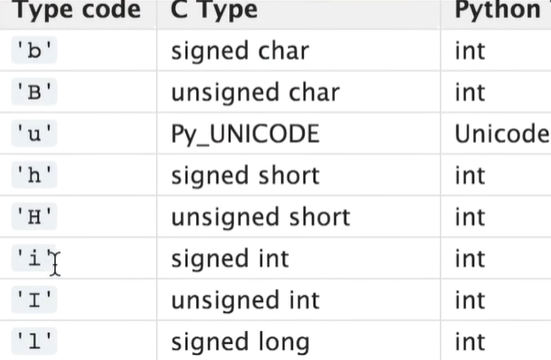

In [17]:
import multiprocessing as mp

mp.Value('d',1)
mp.Array('i',[1,2,3]) # 只能是1维,不能是多维度

<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_int_Array_3 object at 0x7f4ec009db40>>

### 5 Lock

In [9]:
import multiprocessing as mp
import time
import os

def job(v, num):
    for _ in range(10):
        time.sleep(0.1)
        v.value += num
        print(os.getpid(),'* '*4,  v.value)
        
    

def multi_core():
    value = mp.Value('i', 1)
    
    p1 = mp.Process(target=job, args=(value,3,))
    p2 = mp.Process(target=job, args=(value,5,))
    
    p1.start()
    p2.start()
    
    p1.join()
    p2.join()
    
multi_core()

1552715528  * * * * * * * *   49

1552815527  * * * *  * * * *  14
17
1552815527  * * * * * * * *   2522

1552715528  * * * * * * * *   2833

1552715528  * * * * * * * *   3641

1552715528  * * * * 

In [2]:
import multiprocessing as mp
import time
import os

def job(v, num, l):
    l.acquire()
    for _ in range(10):
        time.sleep(0.1)
        v.value += num
        print(os.getpid(), v.value)
    l.release()
        

def multi_core():
    l = mp.Lock()
    value = mp.Value('i', 1)
    
    p1 = mp.Process(target=job, args=(value,3,l,))
    p2 = mp.Process(target=job, args=(value,5,l,))
    
    p1.start()
    p2.start()
    
    p1.join()
    p2.join()
    
multi_core()

13926 4
13926 7
13926 10
13926 13
13926 16
13926 19
13926 22
13926 25
13926 28
13926 31
13927 36
13927 41
13927 46
13927 51
13927 56
13927 61
13927 66
13927 71
13927 76
13927 81


### 6 demo 

In [1]:
# 定义求度分布的函数
def get_pdf(name, N:int, kmin:int, kmax:int, samples:int):
    start_time = time.perf_counter()
    k = list(range(kmin, kmax + 1))  # 将度分布的横坐标设置为[kmin, kmax]区间
    pk = np.zeros(len(k))
    for i in range(samples):
        G = nx.gnp_random_graph(N, avk / N)
        for j in range(len(k)):
            c = 0
            for u in G.nodes():
                if G.degree(u) == k[j]:
                    c += 1
            pk[j] = pk[j] + c / N

    end_time = time.perf_counter()
    print('Process id running on %s = %s' % (name, os.getpid()), '; running time = %s' % (end_time - start_time))

    return pk

串行程序
Process id = 24420.
Process id running on job1 = 24420 ; running time = 15.693508189171553
CPU执行时间(s)= 15.693664819002151 



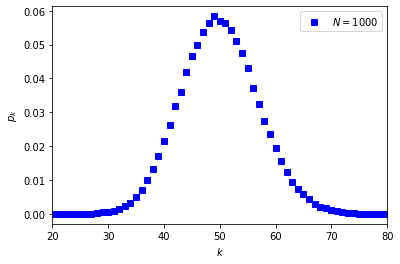

In [5]:
samples = 200  # 总的统计平均次数
N = 1000
# 为了便于统计平均，指定区间[20,80]
kmin, kmax, avk = 20, 80, 50
x = list(range(kmin, kmax + 1))

print('串行程序')
print('Process id = %s.' % os.getpid())
start_time = time.perf_counter()
pk = get_pdf('job1', N, kmin, kmax, samples)
end_time = time.perf_counter()
print('CPU执行时间(s)=', (end_time - start_time), '\n')

plt.figure(figsize=(6,4))
plt.plot(x, pk/samples, 'bs', label='$N = 1000$')
plt.legend(loc=0)
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.xlim([20,80])
plt.show()

mutiprocess

并行程序
Process id = 24420.
Process id running on job1 = 24822 ; running time = 4.192648813128471
Process id running on job2 = 24823 ; running time = 4.193782402202487
Process id running on job3 = 24824 ; running time = 4.202521486207843
Process id running on job4 = 24825 ; running time = 4.214997915551066
运行时间(s)= 4.248009245842695


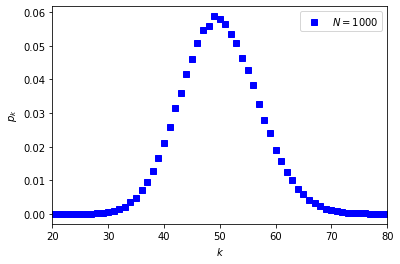

In [7]:
from multiprocessing import Process, Value, Array

# 定义求度分布的函数
def get_pdf(name, N, avk, kmin, kmax, samples, pk):
    start_time = time.perf_counter()
    k = list(range(kmin.value, kmax.value + 1))
    for i in range(samples.value):
        G = nx.gnp_random_graph(N.value, avk.value/N.value)
        for j in range(len(k)):
            c = 0
            for u in G.nodes():
                if G.degree(u) == k[j]:
                    c += 1
            pk[j] = pk[j] + c / N.value

    end_time = time.perf_counter()
    print ('Process id running on %s = %s' % (name, os.getpid()), '; running time = %s' % (end_time-start_time))

cpus = 4
single_samples = Value('i', 50)
samples = single_samples.value * cpus  # 总的统计平均次数

N = Value('i', 1000)
# 为了便于统计平均，指定区间[20,80]
kmin = Value('i', 20)
kmax = Value('i', 80)
avk = Value('d', 50)
x = list(range(kmin.value, kmax.value + 1))
pk = Array('d', np.zeros(len(x), dtype=float))

# 并行程序
print('并行程序')
print('Process id = %s.' % os.getpid())
start_time = time.perf_counter()
p1 = Process(target=get_pdf, args=('job1', N, avk, kmin, kmax, single_samples, pk))
p2 = Process(target=get_pdf, args=('job2', N, avk, kmin, kmax, single_samples, pk))
p3 = Process(target=get_pdf, args=('job3', N, avk, kmin, kmax, single_samples, pk))
p4 = Process(target=get_pdf, args=('job4', N, avk, kmin, kmax, single_samples, pk))
p1.start()
p2.start()
p3.start()
p4.start()
# join()方法可以等待子进程结束后再继续往下运行
p1.join()
p2.join()
p3.join()
p4.join()

end_time = time.perf_counter()
print('运行时间(s)=', (end_time - start_time))

plt.figure(figsize=(6,4))
plt.plot(x, np.array(pk)/samples, 'bs', label='$N = 1000$')
plt.legend(loc=0)
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.xlim([20,80])
plt.show()

### REF

- [multiprocessing：一个在Python中实现多任务并行计算的模块](https://mp.weixin.qq.com/s/Cz0YcJQeUw4fnyWeN-l7fg)
- [multiprocessing --- 基于进程的并行](https://docs.python.org/3/library/multiprocessing.html)
- [多进程Multiprocessing笔记](https://zhuanlan.zhihu.com/p/136995403)
- [多进程multiprocess](https://www.liujiangblog.com/course/python/82)
- [B站：【莫烦Python】Multiprocessing 让你的多核计算机发挥真正潜力 Python](https://www.bilibili.com/video/BV1jW411Y7pv/?spm_id_from=333.337.search-card.all.click)